# Segmenter les clients en fonction de leur comportement d'achat.

In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
import numpy as np

In [ ]:
# Load the dataset
file_path = './supermarket_data.csv'
data = pd.read_csv(file_path)
data.head()

Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  Price  Customer ID         Country  
0  01/12/10 08:26   2.55      17850.0  United Kingdom  
1  01/12/10 08:26   3.39      17850.0  United Kingdom  
2  01/12/10 08:26   2.75      17850.0  United Kingdom  
3  01/12/10 08:26   3.39      17850.0  United Kingdom  
4  01/12/10 08:26   3.39      17850.0  United Kingdom

## Préparation des données

In [ ]:
top_5_prix = data.nlargest(10, 'Price')
print(top_5_prix)

        Invoice  StockCode      Description  Quantity     InvoiceDate  \
222681  C556445          M           Manual        -1  10/06/11 15:31   
524602  C580605  AMAZONFEE       AMAZON FEE        -1  05/12/11 11:36   
43702   C540117  AMAZONFEE       AMAZON FEE        -1  05/01/11 09:55   
43703   C540118  AMAZONFEE       AMAZON FEE        -1  05/01/11 09:57   
15016   C537630  AMAZONFEE       AMAZON FEE        -1  07/12/10 15:04   
15017    537632  AMAZONFEE       AMAZON FEE         1  07/12/10 15:08   
16356   C537651  AMAZONFEE       AMAZON FEE        -1  07/12/10 15:49   
16002   C537644  AMAZONFEE       AMAZON FEE        -1  07/12/10 15:34   
524601  C580604  AMAZONFEE       AMAZON FEE        -1  05/12/11 11:35   
299982  A563185          B  Adjust bad debt         1  12/08/11 14:50   

           Price  Customer ID         Country  
222681  38970.00      15098.0  United Kingdom  
524602  17836.46          NaN  United Kingdom  
43702   16888.02          NaN  United Kingdom  
4370

In [ ]:
# Check for missing values
print(data.isnull().sum())

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64


In [ ]:
# Drop rows with missing values
data = data[(data['Quantity'] > 0) & (data['Price'] > 0)]  # Garder les transactions valides
data = data[data['Price'] < 4000]

In [ ]:
# Drop the data where customerID is null
data = data.dropna(subset=['Customer ID'])

In [ ]:
top_5_prix = data.nlargest(10, 'Price')
print(top_5_prix)

       Invoice StockCode Description  Quantity     InvoiceDate    Price  \
406406  571751         M      Manual         1  19/10/11 11:18  3949.32   
374541  569382         M      Manual         1  03/10/11 16:44  3155.95   
297438  562946         M      Manual         1  11/08/11 09:38  2500.00   
144826  548813         M      Manual         1  04/04/11 13:03  2382.92   
406407  571751         M      Manual         1  19/10/11 11:18  2118.74   
144829  548820         M      Manual         1  04/04/11 13:04  2053.07   
342997  566927         M      Manual         1  15/09/11 15:20  2033.10   
150615  549468         M      Manual         1  08/04/11 14:27  1867.86   
117054  546328         M      Manual         1  11/03/11 10:19  1687.17   
117055  546329         M      Manual         1  11/03/11 10:22  1687.17   

        Customer ID         Country  
406406      12744.0       Singapore  
374541      15502.0  United Kingdom  
297438      15581.0  United Kingdom  
144826      12744.0   

In [ ]:
# Check for missing values after subsetting
print(data.isnull().sum())

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


In [ ]:
# Data preparation: Calculate total spending and average quantity per customer
data.dropna(subset=['Customer ID'], inplace=True)
data['TotalSpend'] = data['Quantity'] * data['Price']

# Group by Customer ID to get total spend, purchase frequency, and average quantity per customer
customer_data = data.groupby('Customer ID').agg({
    'TotalSpend': 'sum',  # Total spending by customer
    'Invoice': 'nunique',  # Frequency of purchases (unique invoices)
    'Quantity': 'mean',    # Average quantity per purchase
    'Country': 'first'     # Representative country for customer
}).rename(columns={'Invoice': 'PurchaseFrequency', 'Quantity': 'AvgQuantity'})
customer_data.head()

TotalSpend  PurchaseFrequency   AvgQuantity         Country
Customer ID                                                             
12346.0        77183.60                  1  74215.000000  United Kingdom
12347.0         4310.00                  7     13.505495         Iceland
12348.0         1797.24                  4     75.516129         Finland
12349.0         1757.55                  1      8.643836           Italy
12350.0          334.40                  1     11.588235          Norway

In [ ]:
# Standardize features for clustering
features_kmeans = customer_data[['TotalSpend', 'PurchaseFrequency', 'AvgQuantity']]
scaler = StandardScaler()
features_kmeans_scaled = scaler.fit_transform(features_kmeans)

## K-Means Clustering

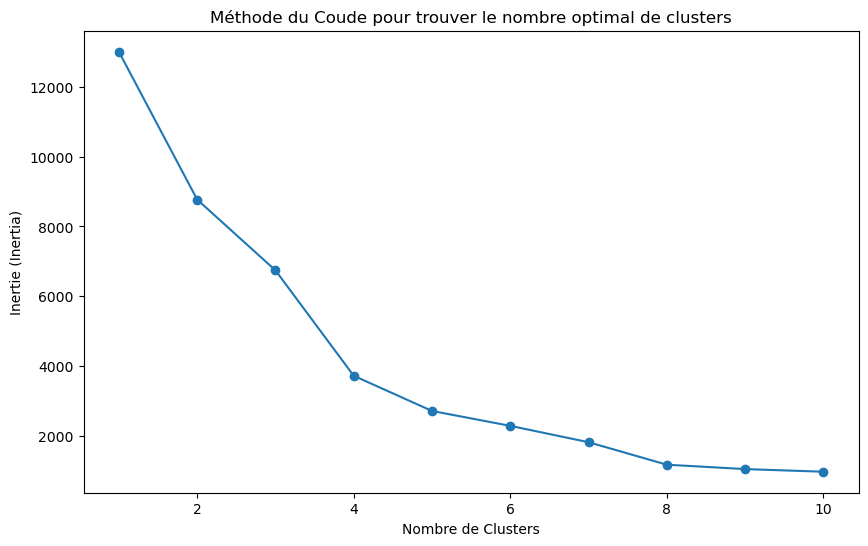

In [ ]:
# Liste pour stocker les scores d'inertie
inertia = []

# Calcul de l'inertie pour différents nombres de clusters
for k in range(1, 11):  # Choisissez un nombre de clusters entre 1 et 10
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features_kmeans_scaled)
    inertia.append(kmeans.inertia_)

# Plot de la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Nombre de Clusters')
plt.ylabel("Inertie (Inertia)")
plt.title("Méthode du Coude pour trouver le nombre optimal de clusters")
plt.show()

In [ ]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_data['KMeansCluster'] = kmeans.fit_predict(features_kmeans_scaled)
customer_data[['TotalSpend', 'PurchaseFrequency', 'AvgQuantity', 'KMeansCluster']].head()

TotalSpend  PurchaseFrequency   AvgQuantity  KMeansCluster
Customer ID                                                            
12346.0        77183.60                  1  74215.000000              2
12347.0         4310.00                  7     13.505495              0
12348.0         1797.24                  4     75.516129              0
12349.0         1757.55                  1      8.643836              0
12350.0          334.40                  1     11.588235              0

**Clustering K-Means** : Les clients ont été divisés en quatre groupes avec des moyennes distinctes pour la dépense totale, la fréquence d'achat et la quantité moyenne. Cette segmentation fournit des informations sur le comportement d'achat des clients et permet d'identifier les acheteurs à haute valeur ou fréquents.

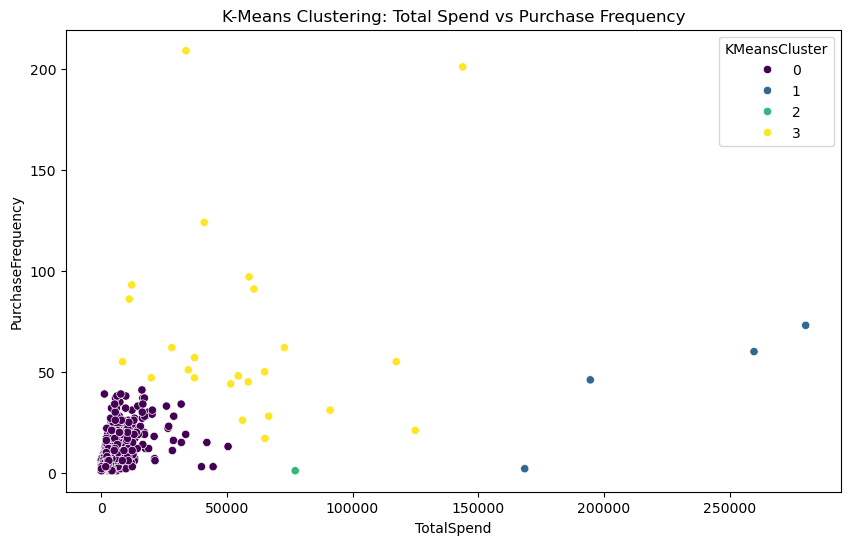

In [ ]:
# Plot K-Means clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='TotalSpend', y='PurchaseFrequency', hue='KMeansCluster', palette='viridis')
plt.title('K-Means Clustering: Total Spend vs Purchase Frequency')
plt.show()

## DBSCAN Clustering

In [ ]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_data['DBSCANCluster'] = dbscan.fit_predict(features_kmeans_scaled)
customer_data[['TotalSpend', 'PurchaseFrequency', 'AvgQuantity', 'DBSCANCluster']].head()

TotalSpend  PurchaseFrequency   AvgQuantity  DBSCANCluster
Customer ID                                                            
12346.0        77183.60                  1  74215.000000             -1
12347.0         4310.00                  7     13.505495              0
12348.0         1797.24                  4     75.516129              0
12349.0         1757.55                  1      8.643836              0
12350.0          334.40                  1     11.588235              0

**Clustering DBSCAN** : Cette méthode a identifié des clusters de base et du "bruit", distinguant potentiellement entre les acheteurs fidèles et occasionnels, bien qu'un ajustement supplémentaire des paramètres puisse offrir des groupements plus affinés.

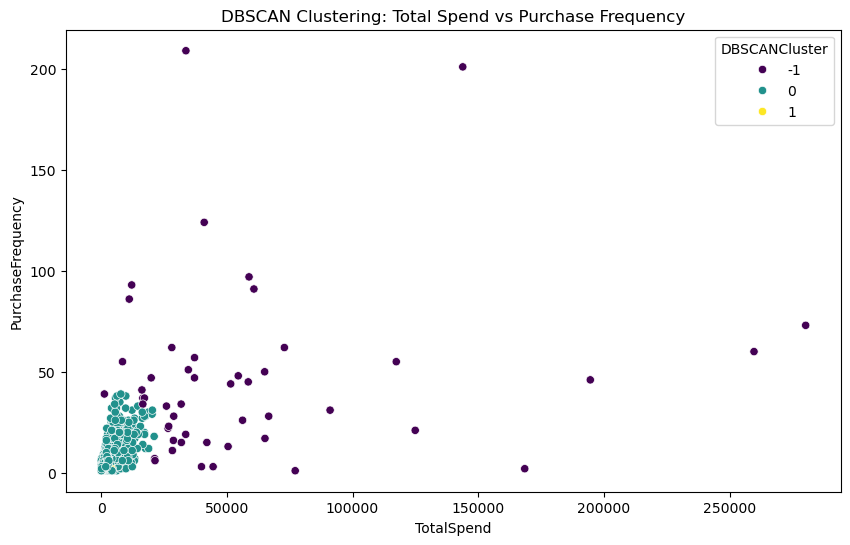

In [ ]:
# Plot DBSCAN clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='TotalSpend', y='PurchaseFrequency', hue='DBSCANCluster', palette='viridis')
plt.title('DBSCAN Clustering: Total Spend vs Purchase Frequency')
plt.show()

## Hierarchical Clustering

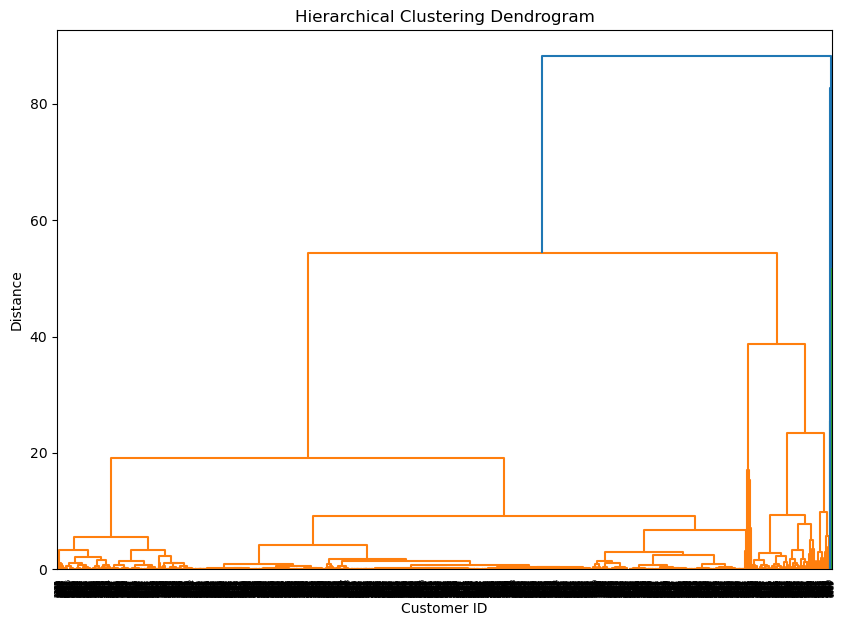

In [ ]:
# Perform hierarchical clustering
Z = linkage(features_kmeans_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customer ID')
plt.ylabel('Distance')
dendrogram(Z)
plt.show()

In [ ]:
# Assign clusters based on hierarchical clustering
customer_data['HierarchicalCluster'] = fcluster(Z, t=4, criterion='maxclust')
customer_data[['TotalSpend', 'PurchaseFrequency', 'AvgQuantity', 'HierarchicalCluster']].head()

TotalSpend  PurchaseFrequency   AvgQuantity  HierarchicalCluster
Customer ID                                                                  
12346.0        77183.60                  1  74215.000000                    4
12347.0         4310.00                  7     13.505495                    1
12348.0         1797.24                  4     75.516129                    1
12349.0         1757.55                  1      8.643836                    1
12350.0          334.40                  1     11.588235                    1

**Clustering Hiérarchique** : Avec le clustering hiérarchique, les clients sont regroupés en clusters imbriqués, permettant une analyse en profondeur et par couches des habitudes d'achat, ce qui peut aider à identifier des sous-groupes au sein de catégories plus générales.

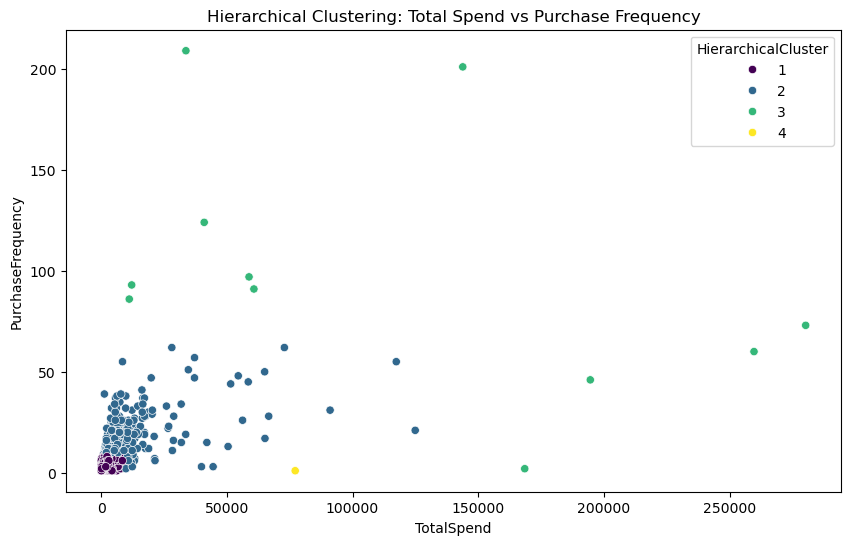

In [ ]:
# Plot hierarchical clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='TotalSpend', y='PurchaseFrequency', hue='HierarchicalCluster', palette='viridis')
plt.title('Hierarchical Clustering: Total Spend vs Purchase Frequency')
plt.show()

# Clustering des Produits en Fonction du Prix Moyen et de la Quantité Totale Vendue

## Préparation des données

In [3]:
# Chargement du jeu de données
file_path = './supermarket_data.csv'
data = pd.read_csv(file_path)
data.head()

Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  Price  Customer ID         Country  
0  01/12/10 08:26   2.55      17850.0  United Kingdom  
1  01/12/10 08:26   3.39      17850.0  United Kingdom  
2  01/12/10 08:26   2.75      17850.0  United Kingdom  
3  01/12/10 08:26   3.39      17850.0  United Kingdom  
4  01/12/10 08:26   3.39      17850.0  United Kingdom

In [ ]:
# Drop rows with missing values
data = data[(data['Quantity'] > 0) & (data['Price'] > 0)]  # Garder les transactions valides
data = data[data['Price'] < 4000]

In [ ]:
# Agrégation des données par produit
product_data = data.groupby('StockCode').agg({
    'Price': 'mean',       # Prix moyen par produit
    'Quantity': 'sum'      # Quantité totale vendue par produit
}).rename(columns={'Price': 'AvgPrice', 'Quantity': 'TotalQuantity'})
product_data.head()

AvgPrice  TotalQuantity
StockCode                         
10002      1.086620            860
10080      0.410909            303
10120      0.210000            193
10123C     0.650000              5
10124A     0.420000             16

In [ ]:
# Standardisation des caractéristiques pour le clustering
scaler = StandardScaler()
product_features_scaled = scaler.fit_transform(product_data)

## Clustering K-Means

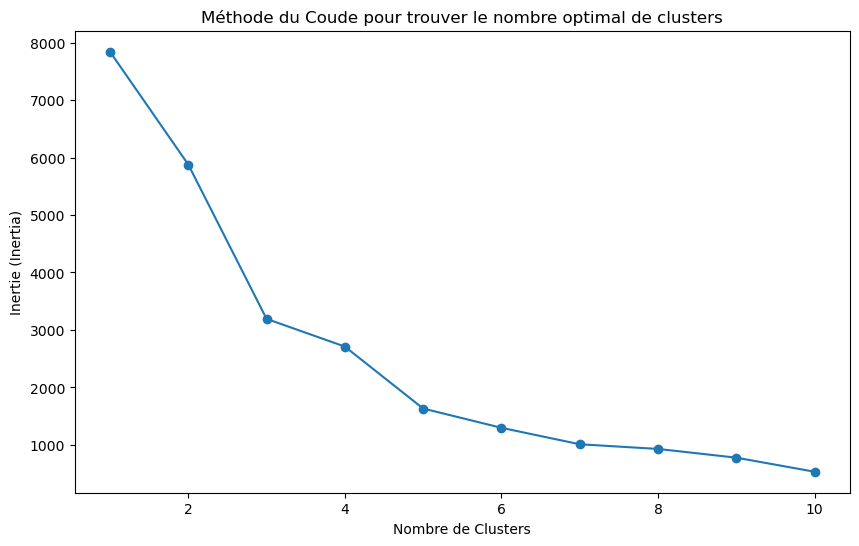

In [ ]:
# Liste pour stocker les scores d'inertie
inertia = []

# Calcul de l'inertie pour différents nombres de clusters
for k in range(1, 11):  # Choisissez un nombre de clusters entre 1 et 10
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(product_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot de la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Nombre de Clusters')
plt.ylabel("Inertie (Inertia)")
plt.title("Méthode du Coude pour trouver le nombre optimal de clusters")
plt.show()

In [ ]:
# Application de l'algorithme de clustering K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
product_data['KMeansCluster'] = kmeans.fit_predict(product_features_scaled)
product_data[['AvgPrice', 'TotalQuantity', 'KMeansCluster']].head()

AvgPrice  TotalQuantity  KMeansCluster
StockCode                                        
10002      1.086620            860              0
10080      0.410909            303              0
10120      0.210000            193              0
10123C     0.650000              5              0
10124A     0.420000             16              0

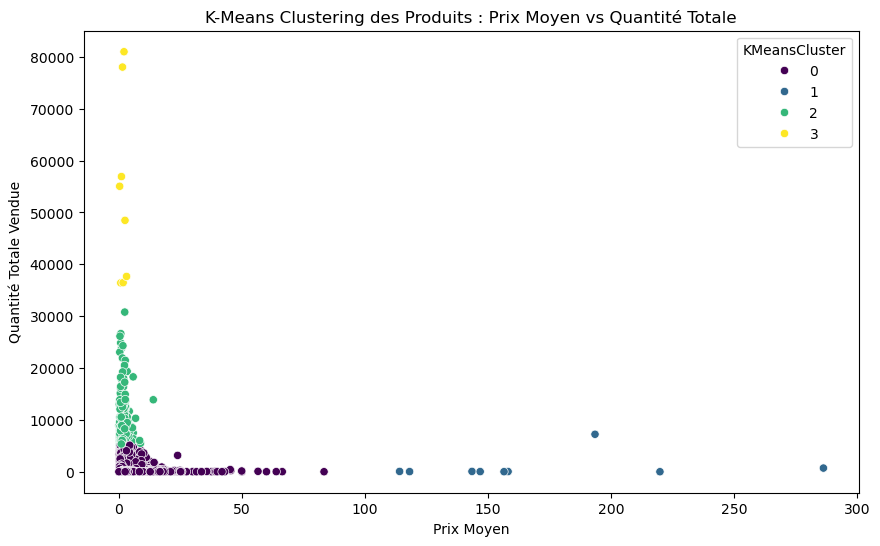

In [ ]:
# Visualisation des clusters de produits
plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_data, x='AvgPrice', y='TotalQuantity', hue='KMeansCluster', palette='viridis')
plt.title('K-Means Clustering des Produits : Prix Moyen vs Quantité Totale')
plt.xlabel('Prix Moyen')
plt.ylabel('Quantité Totale Vendue')
plt.show()

In [ ]:
# Résumé des clusters K-Means
product_summary = product_data.groupby('KMeansCluster')[['AvgPrice', 'TotalQuantity']].mean()
product_summary

AvgPrice  TotalQuantity
KMeansCluster                           
0                3.858612     792.658131
1              170.676017     904.444444
2                1.905926    9615.330472
3                1.624344   53751.250000

## DBSCAN Clustering

In [ ]:
# Définir les valeurs à tester pour eps et min_samples
eps_values = np.arange(0.1, 2.1, 0.1)  # Tester différents eps
min_samples_values = [3, 4, 5, 6]  # Tester différents min_samples

# Liste pour stocker les scores silhouette
sil_scores = []

# Test pour chaque combinaison de paramètres
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(product_features_scaled)

        # Calcul du silhouette score (il faut que le nombre de clusters soit supérieur à 1)
        if len(set(labels)) > 1:
            score = silhouette_score(product_features_scaled, labels)
            sil_scores.append((eps, min_samples, score))

# Trouver la meilleure combinaison d'eps et min_samples
best_params = max(sil_scores, key=lambda x: x[2])

print(f"Meilleurs paramètres : eps={best_params[0]}, min_samples={best_params[1]}, silhouette score={best_params[2]}")

Meilleurs paramètres : eps=2.0, min_samples=5, silhouette score=0.9493236855839324


In [ ]:
# Application de DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=5)
product_data['DBSCANCluster'] = dbscan.fit_predict(product_features_scaled)

# Affichage des premiers résultats
product_data[['AvgPrice', 'TotalQuantity', 'DBSCANCluster']].head()

AvgPrice  TotalQuantity  DBSCANCluster
StockCode                                        
10002      1.086620            860              0
10080      0.410909            303              0
10120      0.210000            193              0
10123C     0.650000              5              0
10124A     0.420000             16              0

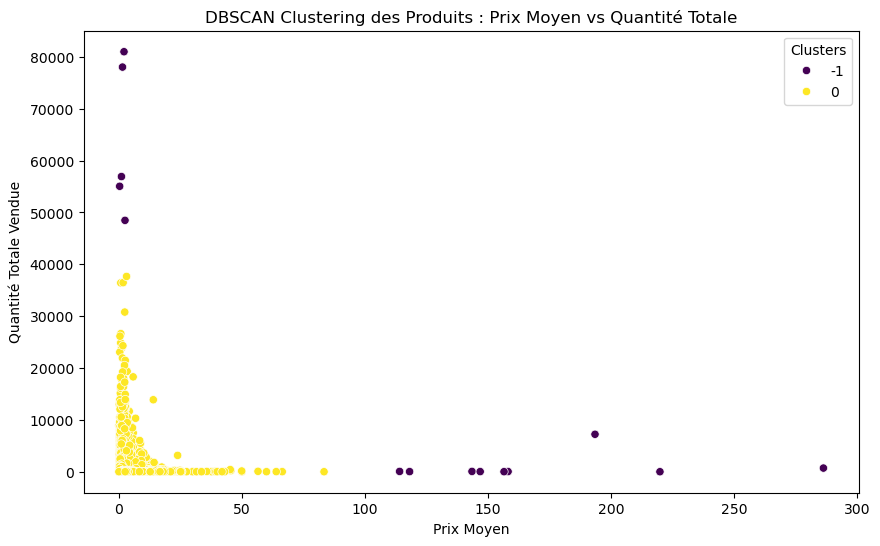

In [ ]:
# Visualisation des clusters DBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_data, x='AvgPrice', y='TotalQuantity', hue='DBSCANCluster', palette='viridis')
plt.title('DBSCAN Clustering des Produits : Prix Moyen vs Quantité Totale')
plt.xlabel('Prix Moyen')
plt.ylabel('Quantité Totale Vendue')
plt.legend(title='Clusters')
plt.show()

## Gaussian Mixture Clustering

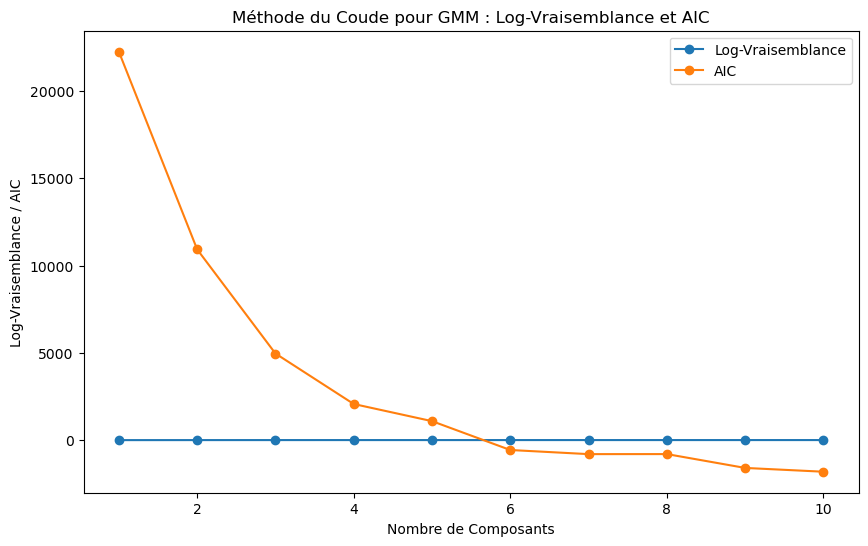

In [ ]:
# Liste pour stocker la log-vraisemblance (ou AIC)
log_likelihoods = []
aics = []

# Tester pour un nombre de composants de 1 à 10
for n_components in range(1, 11):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(product_features_scaled)
    log_likelihoods.append(gmm.lower_bound_)
    aics.append(gmm.aic(product_features_scaled))

# Tracer le graphique de la log-vraisemblance (ou AIC)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), log_likelihoods, marker='o', label='Log-Vraisemblance')
plt.plot(range(1, 11), aics, marker='o', label='AIC')
plt.title('Méthode du Coude pour GMM : Log-Vraisemblance et AIC')
plt.xlabel('Nombre de Composants')
plt.ylabel('Log-Vraisemblance / AIC')
plt.legend()
plt.show()

In [ ]:
# Application du Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)
product_data['GMMCluster'] = gmm.fit_predict(product_features_scaled)

# Affichage des premiers résultats
product_data[['AvgPrice', 'TotalQuantity', 'GMMCluster']].head()

AvgPrice  TotalQuantity  GMMCluster
StockCode                                     
10002      1.086620            860           0
10080      0.410909            303           0
10120      0.210000            193           0
10123C     0.650000              5           0
10124A     0.420000             16           0

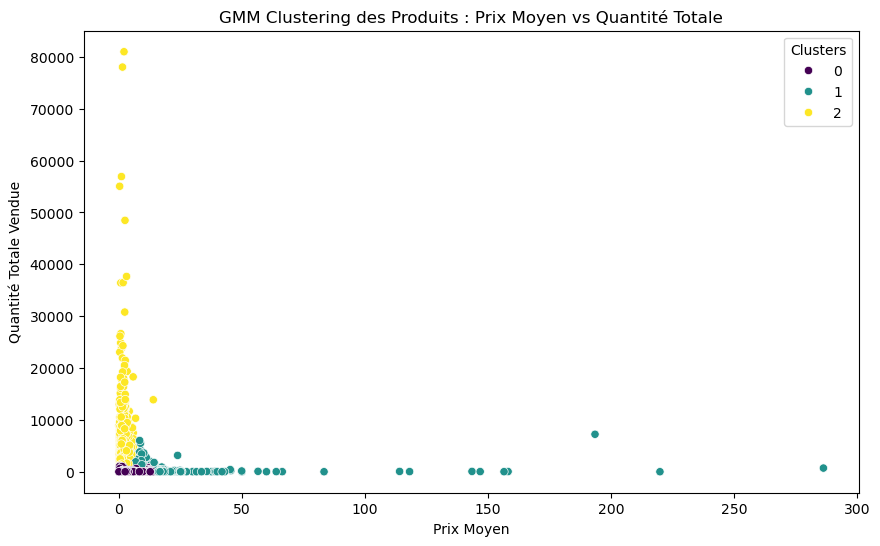

In [ ]:
# Visualisation des clusters GMM
plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_data, x='AvgPrice', y='TotalQuantity', hue='GMMCluster', palette='viridis')
plt.title('GMM Clustering des Produits : Prix Moyen vs Quantité Totale')
plt.xlabel('Prix Moyen')
plt.ylabel('Quantité Totale Vendue')
plt.legend(title='Clusters')
plt.show()

# Analyse graphique/ temporelle

In [ ]:
import pandas as pd
import networkx as nx
import community  # Pour la détection de communautés avec Louvain
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain  # Corriger l'importation
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
# Chargement du dataset (supposons que tu as un CSV ou DataFrame)
df = pd.read_csv('supermarket_data.csv')

df_analyse_temporelle = df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# Vérifier les lignes contenant des valeurs nulles
null_rows = df[df.isnull().any(axis=1)]

# Compter le nombre de lignes contenant des valeurs nulles
num_null_rows = len(null_rows)
print(f"Nombre de lignes contenant des valeurs nulles : {num_null_rows}")

# Afficher 2 ou 3 instances de lignes avec des valeurs nulles
print("Exemples de lignes contenant des valeurs nulles :")
null_rows.head(3)

Nombre de lignes contenant des valeurs nulles : 135080
Exemples de lignes contenant des valeurs nulles :


Invoice StockCode                      Description  Quantity  \
622   536414     22139                              NaN        56   
1443  536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1   
1444  536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2   

         InvoiceDate  Price  Customer ID         Country  
622   01/12/10 11:52   0.00          NaN  United Kingdom  
1443  01/12/10 14:32   2.51          NaN  United Kingdom  
1444  01/12/10 14:32   2.51          NaN  United Kingdom

Les descriptions manquantes ont été complétées automatiquement lorsqu'un produit avec le même StockCode avait déjà une description disponible dans le dataset. (1342 descriptions completées)

In [ ]:
# Identifier les lignes où la description est manquante
missing_description = df[df['Description'].isnull()]

# Créer un dictionnaire pour associer chaque StockCode à une Description non nulle
stockcode_to_description = df.dropna(subset=['Description']).set_index('StockCode')['Description'].to_dict()

# Remplir les descriptions manquantes si le StockCode existe dans le dictionnaire
df['Description'] = df.apply(
    lambda row: stockcode_to_description[row['StockCode']]
    if pd.isnull(row['Description']) and row['StockCode'] in stockcode_to_description
    else row['Description'],
    axis=1
)

# Vérifier combien de descriptions ont été remplies
filled_count = len(missing_description) - df['Description'].isnull().sum()
print(f"Nombre de descriptions remplies automatiquement : {filled_count}")

Nombre de descriptions remplies automatiquement : 1342


Ce code complète les **Customer IDs** manquants en vérifiant si une autre ligne avec le même **Invoice ID** en possède déjà un valide, puis on utilise cette information pour remplir les données manquantes. ( 0 **Customer IDs** remplis )

In [ ]:
# Identifier les lignes où Customer ID est manquant
missing_customer_id = df[df['Customer ID'].isnull()]

# Créer un dictionnaire associant chaque Invoice ID à un Customer ID valide (si disponible)
invoice_to_customer = df.dropna(subset=['Customer ID']).set_index('Invoice')['Customer ID'].to_dict()

# Remplir les Customer ID manquants si l'Invoice ID est présent dans le dictionnaire
df['Customer ID'] = df.apply(
    lambda row: invoice_to_customer[row['Invoice']]
    if pd.isnull(row['Customer ID']) and row['Invoice'] in invoice_to_customer
    else row['Customer ID'],
    axis=1
)

# Vérifier combien de Customer IDs ont été remplis
filled_count = len(missing_customer_id) - df['Customer ID'].isnull().sum()
print(f"Nombre de Customer IDs remplis automatiquement : {filled_count}")

Nombre de Customer IDs remplis automatiquement : 0


### Gestion des valeurs manquantes dans le dataset

En analysant les données, plusieurs colonnes contiennent des valeurs nulles, notamment la colonne **Customer ID**, qui a un grand nombre de valeurs manquantes (environ 28 % des transactions).

Pour les transactions où **Customer ID** est manquant, il est impossible de déterminer si la transaction provient d'un client existant ou d'un nouveau client. Plutôt que de supposer qu'il s'agit d'un client existant ou d'en créer un nouveau client ID, il est plus judicieux de supprimer ces lignes.

Pour les lignes restantes sans description, elles seront supprimées car aucune information produit n'est disponible pour les compléter. Bien que ces lignes puissent être conservées sans impact majeur sur l'analyse, elles n'apportent pas de valeur significative

In [ ]:
df = df.dropna()

In [ ]:
# Filtrer les lignes où la quantité est négative
negative_quantity = df[df['Quantity'] < 0]

print(len(negative_quantity))

# Afficher 5 exemples de ces lignes
print("Lignes avec une quantité négative :")
negative_quantity.head(5)

8905
Lignes avec une quantité négative :


Invoice StockCode                       Description  Quantity  \
141  C536379         D                          Discount        -1   
154  C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235  C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236  C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237  C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

        InvoiceDate  Price  Customer ID         Country  
141  01/12/10 09:41  27.50      14527.0  United Kingdom  
154  01/12/10 09:49   4.65      15311.0  United Kingdom  
235  01/12/10 10:24   1.65      17548.0  United Kingdom  
236  01/12/10 10:24   0.29      17548.0  United Kingdom  
237  01/12/10 10:24   0.29      17548.0  United Kingdom

Les lignes avec des quantités négatives semblent correspondre à des retours ou des ajustements de stock, tels que des discounts ou des frais Amazon. Bien que ces valeurs puissent être importantes dans un contexte commercial complet, pour cette analyse, nous avons décidé de les supprimer en conservant uniquement les transactions avec des quantités positives, afin de garantir la cohérence des données et de se concentrer sur les ventes réelles.

In [ ]:
# Filtrer les quantités négatives (produits retournés)
df = df[df['Quantity'] > 0]

In [ ]:
# Création d'un graphe bipartite
G = nx.Graph()

On ajoute des nœuds au graphe bipartite, où les nœuds de type 0 représentent

---

les **clients** (en utilisant les **Customer ID** du dataset), et les nœuds de type 1 représentent les **produits** (en utilisant les **StockCode**). Cette structuration permet à on de modéliser les relations entre les clients et les produits dans un graphe bipartite, facilitant ainsi l'analyse des interactions entre ces deux groupes.

In [ ]:
# Ajouter les nœuds (clients et produits)
G.add_nodes_from(df['Customer ID'], bipartite=0)  # Clients
G.add_nodes_from(df['StockCode'], bipartite=1)   # Produits

In [ ]:
# Ajouter les arêtes entre clients et produits
for _, row in df.iterrows():
    G.add_edge(row['Customer ID'], row['StockCode'])

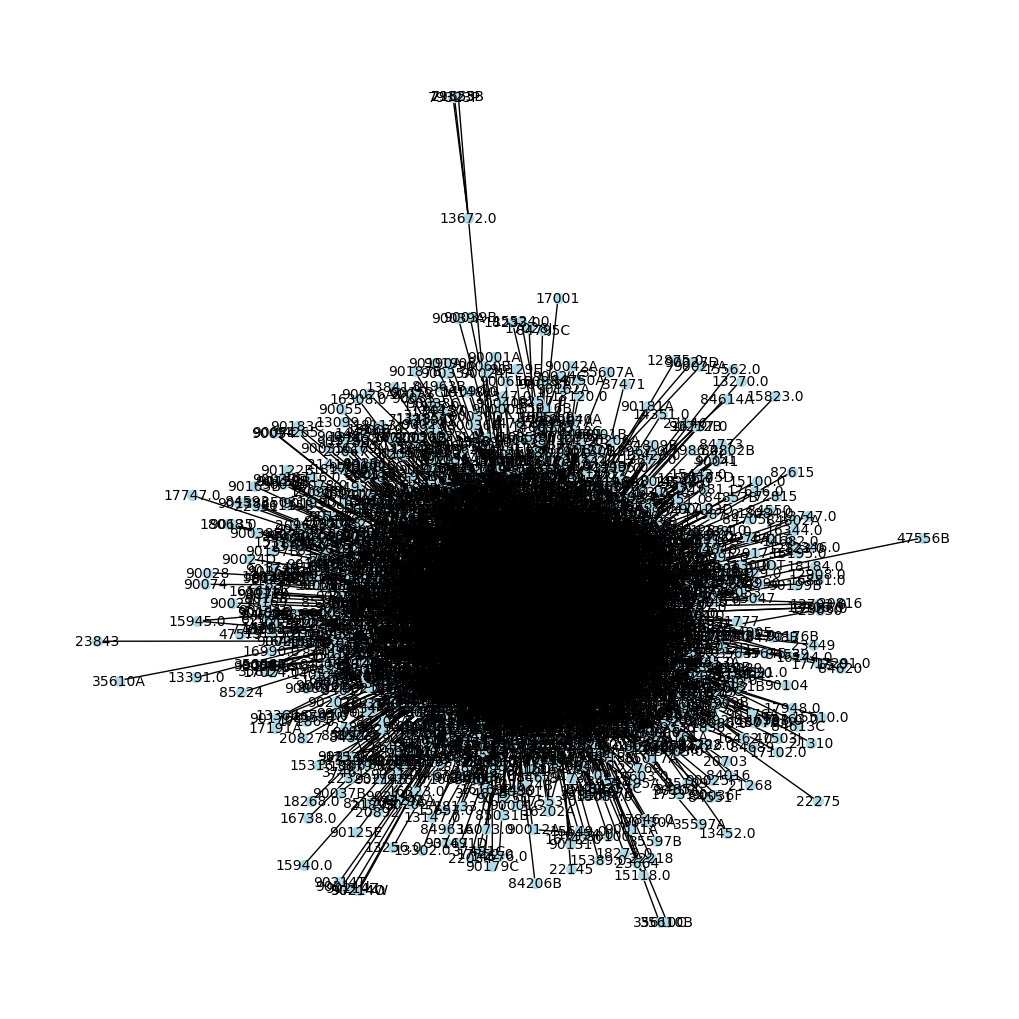

In [ ]:
# Visualiser le graphe
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=50, node_color="lightblue", font_size=10)
plt.show()

In [ ]:
# Exporter le graphe dans un fichier GraphML pour Gephi
nx.write_graphml(G, "supermarket_graph.graphml")
print("Graphe exporté sous 'supermarket_graph.graphml'")

Graphe exporté sous 'supermarket_graph.graphml'


# Community detection :

Le but de la détection de communautés est d'identifier des groupes de nœuds (clients et produits) qui sont fortement interconnectés, ce qui peut permettre de découvrir des motifs ou des relations cachées dans les données, comme des groupes de clients ayant des comportements d'achat similaires ou des produits fréquemment achetés ensemble.

Dans ce cas, le résultat attendu de cette analyse n'est pas nécessairement de déterminer un nombre précis de communautés, car le graphe peut être dense et complexe, rendant difficile la visualisation et l'interprétation directe des groupes. Cependant, l'algorithme de Louvain a détecté 6 communautés, ce qui suggère qu'il y a des sous-ensembles de clients et de produits qui interagissent de manière plus étroite

Nombre de communautés détectées : 6


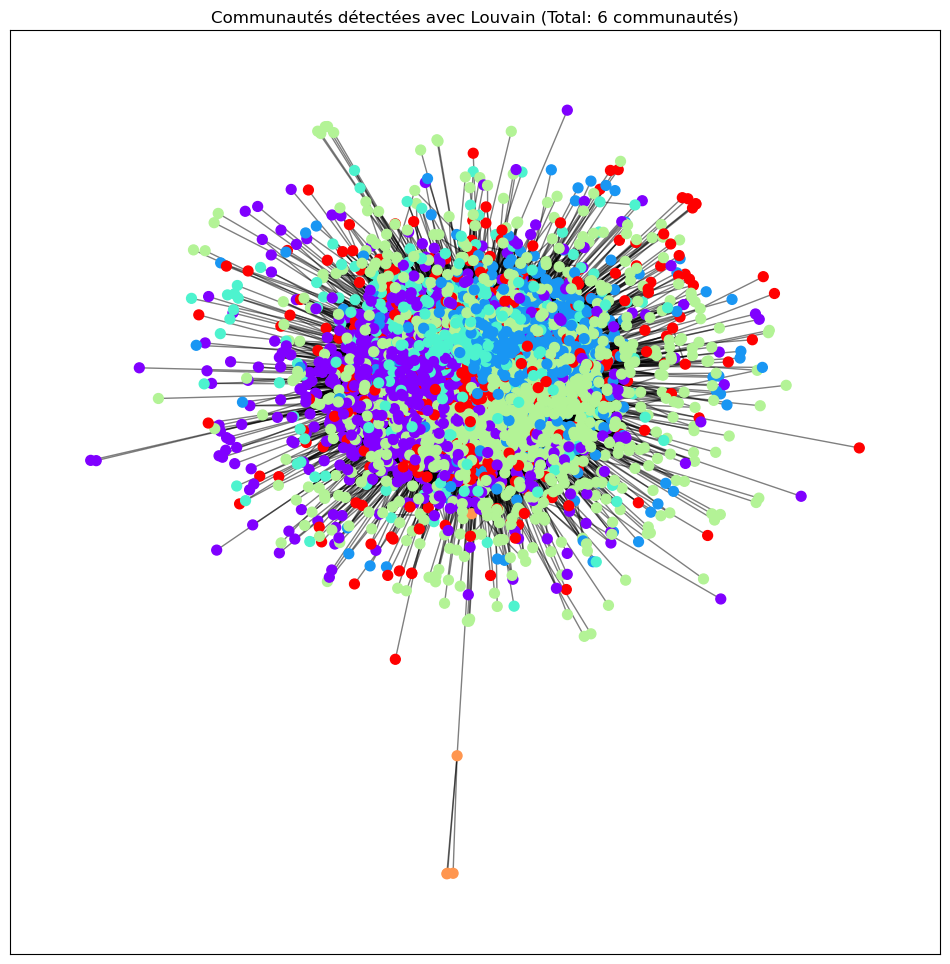

In [ ]:
# --- Détection de communautés avec Louvain ---
partition = community_louvain.best_partition(G)

# Nombre de communautés détectées
num_communities = len(set(partition.values()))
print(f"Nombre de communautés détectées : {num_communities}")

# --- Visualisation des communautés ---
pos = nx.spring_layout(G)  # Position des nœuds dans le graphique

# Créer une liste de couleurs pour chaque communauté
colors = [partition[node] for node in G.nodes()]

# Visualiser le graphe avec les couleurs des communautés
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.rainbow, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title(f"Communautés détectées avec Louvain (Total: {num_communities} communautés)")
plt.show()

### Comparaison de la détection de communautés avec l'algorithme Girvan-Newman et l'algorithme Louvain

L'objectif initial était d'utiliser l'algorithme **Girvan-Newman** pour comparer ses résultats de détection de communautés avec ceux obtenus par l'algorithme **Louvain**. Cependant, lorsqu'on a tenté d'exécuter l'algorithme Girvan-Newman, l'exécution a pris un temps considérable. Cet algorithme est effectivement connu pour sa lenteur, surtout sur des graphes de grande taille, en raison de la suppression récursive des arêtes les plus centrales.


In [ ]:
# # --- Détection de communautés avec l'algorithme de Girvan-Newman ---
# communities_generator = girvan_newman(G)

# # Limiter le nombre de niveaux à explorer
# # Limite d'itérations pour éviter des calculs longs
# max_levels = 5

# best_communities = None
# level = 1

# # Explorer les communautés sans calculer la modularité à chaque niveau
# for communities in communities_generator:
#     if level > max_levels:
#         break

#     # Convertir les communautés en liste
#     communities_list = [list(community) for community in communities]

#     # Ici, vous pouvez choisir d'arrêter après un certain nombre de niveaux ou selon un critère personnalisé
#     # Par exemple, ici on choisit d'arrêter après 'max_levels' niveaux
#     best_communities = communities_list

#     level += 1

# print(f"\nCommunautés optimales après {level-1} niveaux :")
# print(best_communities)

# # --- Visualisation des communautés optimales ---
# pos = nx.spring_layout(G)
# plt.figure(figsize=(12, 12))

# colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'cyan', 'magenta']
# for i, community in enumerate(best_communities):
#     nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=colors[i % len(colors)], node_size=50)

# nx.draw_networkx_edges(G, pos, alpha=0.5)
# plt.title("Communautés optimales selon Girvan-Newman")
# plt.show()

# Top 5 des clients en fonction du nombre de produits achetés et top 5 des produits achetés en utilisant **Degree Centrality** et **Closeness Centrality**.

Le but est de déterminer les entités les plus influentes ou centrales dans les réseaux de relations entre clients et produits, en utilisant des mesures de centralité.

Ce type d'analyse peut être utilisé pour identifier les clients les plus importants en termes de nombre d'achats (degré de centralité) ou ceux ayant un impact global plus large dans le réseau d'achats (centralité de proximité). Cela permettrait aux entreprises de cibler ces clients pour des promotions, des offres spéciales ou des programmes de fidélité.

De même, pour les produits, déterminer les produits les plus centraux permettrait de comprendre lesquels sont les plus populaires ou influents dans le réseau d'achats, ce qui peut aider à mieux organiser les stocks, optimiser la gestion des produits ou même ajuster les stratégies marketing pour promouvoir des produits clés qui captent l'attention des clients.

In [ ]:
# Calculer les centralités
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Pour chaque centralité, filtrer les nœuds en fonction du type (clients ou produits) et trier pour obtenir le top 5
def get_top_entities(centrality, n=5, node_type='Customer ID'):
    # Filtrer les nœuds en fonction de leur type (client ou produit)
    nodes = [node for node in centrality if (node in df[node_type].values)]
    # Trier les nœuds par centralité et extraire les n premiers
    sorted_nodes = sorted(nodes, key=lambda x: centrality[x], reverse=True)
    return sorted_nodes[ :n]

# Afficher les résultats
print("Top 5 clients par degré:", get_top_entities(degree_centrality, node_type='Customer ID'))
print("Top 5 produits par degré:", get_top_entities(degree_centrality, node_type='StockCode'))
print("Top 5 clients par closeness:", get_top_entities(closeness_centrality, node_type='Customer ID'))
print("Top 5 produits par closeness:", get_top_entities(closeness_centrality, node_type='StockCode'))

Top 5 clients par degré: [14911.0, 12748.0, 17841.0, 14096.0, 14298.0]
Top 5 produits par degré: ['22423', '85123A', '47566', '84879', '22720']
Top 5 clients par closeness: [14911.0, 12748.0, 17841.0, 14096.0, 14298.0]
Top 5 produits par closeness: ['22423', '85123A', '47566', '84879', '22720']


# Top 5 des produits en prenant en compte la quantité vendue comme poids dans les arêtes et en utilisant la centralité pondérée pour retourner les 5 meilleurs produits

cette analyse permet d'identifier les produits les plus populaires en prenant en compte non seulement leur fréquence de vente, mais aussi la quantité totale vendue, ce qui peut fournir une vision plus précise de leur importance économique. Contrairement à l'analyse précédente, qui se concentrait sur les produits les plus "connectés" dans le réseau des transactions (centralité de degré ou de proximité), cette méthode prend en compte l'intensité des ventes pour attribuer un poids plus élevé aux produits avec des ventes massives, offrant ainsi une perspective plus complète sur les produits qui génèrent réellement le plus de revenus.

In [ ]:
for _, row in df.iterrows():
    customer = row['Customer ID']
    product = row['StockCode']
    quantity = row['Quantity']

    if G.has_edge(customer, product):
        if 'weight' in G[customer][product]:
            G[customer][product]['weight'] += quantity
        else:
            G[customer][product]['weight'] = quantity
    else:
        G.add_edge(customer, product, weight=quantity)

In [ ]:
# Calculer la centralité de proximité pondérée
closeness_centrality_weighted = nx.closeness_centrality(G, distance='weight')

# Obtenir le top 5 produits pour chaque mesure de centralité pondérée
def get_top_5_products(centrality):
    # Filtrer les produits uniquement
    products = {node: centrality[node] for node in centrality if node in df['StockCode'].values}
    # Trier les produits par centralité décroissante
    return sorted(products, key=products.get, reverse=True)[:5]

# Afficher les résultats
print("Top 5 produits par centralité de proximité pondérée:", get_top_5_products(closeness_centrality_weighted))

Top 5 produits par centralité de proximité pondérée: ['22423', '21770', '22487', '21034', '22776']


# Top 5 clients par leurs dépenses dans le magasin à l'aide de la centralité pondérée

Cette analyse classe les clients en fonction de leurs dépenses totales dans le magasin, en utilisant la centralité pondérée pour prendre en compte le montant de chaque achat plutôt que simplement la fréquence ou la quantité des produits achetés. Contrairement à l'analyse précédente, qui se concentrait sur l'activité des clients en fonction du nombre de produits achetés ou de leur position dans le réseau, cette approche permet de mieux comprendre l'impact économique des clients en fonction de leurs dépenses globales, ce qui est essentiel pour cibler les clients les plus rentables pour des promotions ou des stratégies de fidélisation.

In [ ]:
if 'Depense' not in df.columns:
    df['Depense'] = df['Quantity'] * df['Price']  # Calculer le chiffre d'affaires pour chaque ligne

# Ajouter les arêtes entre clients et produits avec 'depense' comme poids
for _, row in df.iterrows():
    customer = row['Customer ID']
    product = row['StockCode']
    depense = row['Depense']  # Utiliser le chiffre d'affaires comme poids

    if G.has_edge(customer, product):
        # Si l'arête existe déjà, on incrémente le poids (chiffre d'affaires)
        if 'weight' in G[customer][product]:
            G[customer][product]['weight'] += depense
        else:
            G[customer][product]['weight'] = depense
    else:
        # Sinon, on crée une nouvelle arête avec le poids (chiffre d'affaires)
        G.add_edge(customer, product, weight=depense)


# Calculer la centralité pondérée (ici on utilise la centralité de degré pondéré)
closeness_centrality_weighted = nx.closeness_centrality(G, distance='weight')

# Obtenir les top 5 clients par chiffre d'affaires (basé sur la centralité pondérée)
def get_top_5_clients_by_depense(centrality):
    # Filtrer les nœuds 'Customer ID' et trier en fonction de la centralité pondérée
    customer_centrality = {node: centrality[node] for node in centrality if node in df['Customer ID'].values}
    sorted_customers = sorted(customer_centrality.items(), key=lambda x: x[1], reverse=True)
    return sorted_customers[:5]

# Afficher les top 5 clients basés sur la centralité pondérée
top_5_clients = get_top_5_clients_by_depense(closeness_centrality_weighted)
print("Top 5 clients par chiffre d'affaires :")
for customer, centrality in top_5_clients:
    print(f"Client {customer} ")

Top 5 clients par chiffre d'affaires :
Client 14456.0 
Client 12748.0 
Client 17841.0 
Client 13521.0 
Client 16910.0 


# Analyse Temporelle

Dans cette analyse, j'ai décidé de conserver le premier dataset sans supprimer les valeurs manquantes, car l'élimination de ces valeurs pourrait altérer les résultats, en particulier pour l'analyse temporelle des achats par mois.

L'analyse du nombre d'achats par mois permet d'observer les tendances d'achat au fil du temps et de détecter des motifs saisonniers ou des variations périodiques dans les comportements des consommateurs. Cela peut être utile dans un contexte commercial pour comprendre les périodes de forte demande (par exemple, pendant les vacances ou des événements spéciaux) et ajuster les stratégies de marketing ou d'approvisionnement en conséquence.

En visualisant cette évolution, on peut mieux planifier les stocks, identifier les périodes de ralentissement et maximiser les ventes pendant les périodes de forte activité. L'ACF (AutoCorrelation Function) permet, quant à elle, de mesurer la similarité des achats à des périodes précédentes, ce qui peut aider à prédire les tendances futures et à affiner les stratégies en fonction des cycles observés, comme les périodes de promotions ou les tendances saisonnières.

In [ ]:
# Convertir la colonne 'InvoiceDate' en format datetime si ce n'est pas déjà fait
df_analyse_temporelle['InvoiceDate'] = pd.to_datetime(df_analyse_temporelle['InvoiceDate'], format='%d/%m/%y %H:%M')

# Obtenir les dates minimale et maximale
date_min = df_analyse_temporelle['InvoiceDate'].min()
date_max = df_analyse_temporelle['InvoiceDate'].max()

print(f"Date minimale : {date_min}")
print(f"Date maximale : {date_max}")

Date minimale : 2010-12-01 08:26:00
Date maximale : 2011-12-09 12:50:00


In [ ]:
# Assurez-vous que la colonne InvoiceDate est au format datetime
df_analyse_temporelle['InvoiceDate'] = pd.to_datetime(df_analyse_temporelle['InvoiceDate'])

# Extraire le mois et l'année de la date d'achat
df_analyse_temporelle['Month'] = df_analyse_temporelle['InvoiceDate'].dt.to_period('M')

# Calculer le nombre d'achats par mois
purchase_count_by_month = df_analyse_temporelle.groupby('Month').size()

print(len(purchase_count_by_month))

# Afficher les premiers résultats pour vérifier
purchase_count_by_month

13


Month
2010-12    42481
2011-01    35147
2011-02    27707
2011-03    36748
2011-04    29916
2011-05    37030
2011-06    36874
2011-07    39518
2011-08    35284
2011-09    50226
2011-10    60742
2011-11    84711
2011-12    25526
Freq: M, dtype: int64

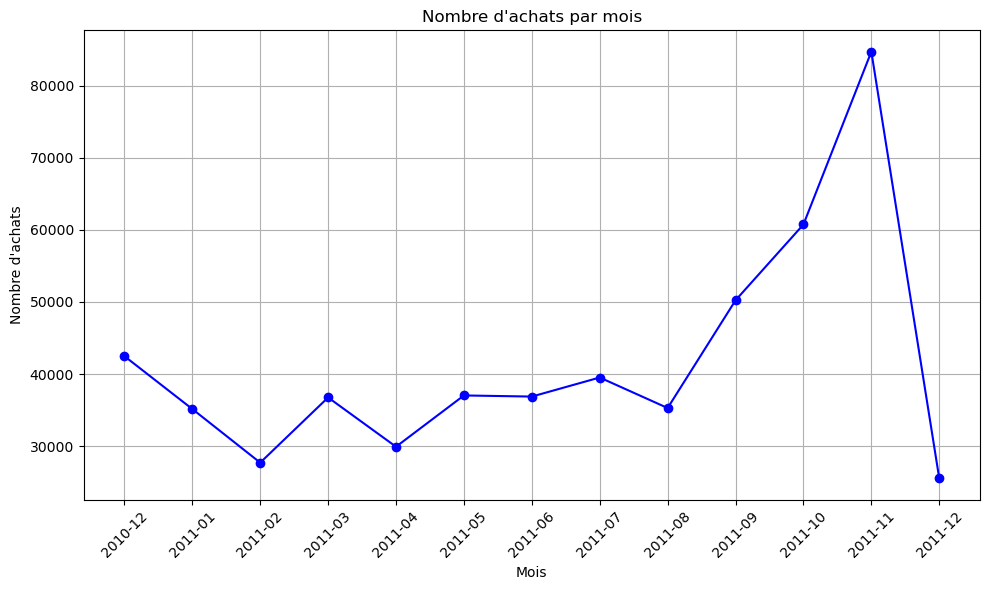

In [ ]:
# Convertir l'index de la série en chaîne de caractères pour l'affichage
plt.figure(figsize=(10, 6))
plt.plot(purchase_count_by_month.index.astype(str), purchase_count_by_month.values, marker='o', color='b')
plt.title('Nombre d\'achats par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'achats')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

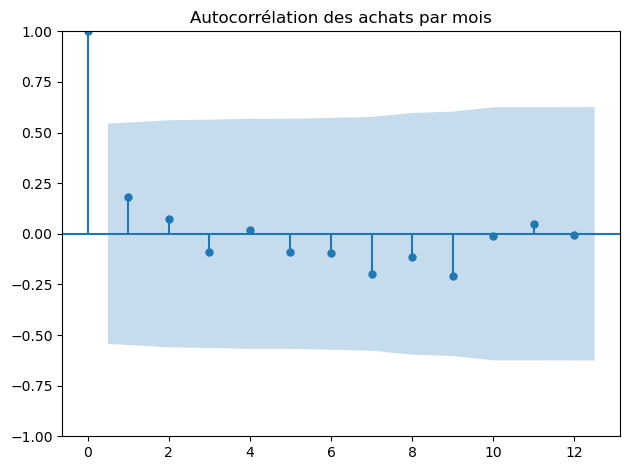

In [ ]:
# Plot de l'ACF avec lags
plt.figure(figsize=(10, 6))
plot_acf(purchase_count_by_month, lags=12)
plt.title('Autocorrélation des achats par mois')
plt.tight_layout()
plt.show()

ces graphiques montre une hausse marquée des achats en fin d'année 2011 (octobre et novembre), probablement due à des facteurs saisonniers tels que des promotions ou des fêtes. La forte baisse en décembre pourrait s'expliquer par une fin de campagne ou des données incomplètes. L'analyse d'autocorrélation révèle une faible dépendance à court terme entre les mois, suggérant que les achats ne suivent pas un cycle clair sur l'année, mais des pics saisonniers peuvent influencer les tendances.

# Analyse des Règles d’Association et Visualisation des Relations Produits ( Frequent Pattern )

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules, association_rules

In [ ]:
# Charger le dataset
df = pd.read_csv('supermarket_data.csv')

# Afficher les premières lignes du dataset pour observer la structure
print(df.head())

  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  Price  Customer ID         Country  
0  01/12/10 08:26   2.55      17850.0  United Kingdom  
1  01/12/10 08:26   3.39      17850.0  United Kingdom  
2  01/12/10 08:26   2.75      17850.0  United Kingdom  
3  01/12/10 08:26   3.39      17850.0  United Kingdom  
4  01/12/10 08:26   3.39      17850.0  United Kingdom  


In [ ]:
# Vérifier les informations du DataFrame (types de données, valeurs manquantes, etc.)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [ ]:
# Vérifier la présence de valeurs manquantes
print(df.isnull().sum())

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64


In [ ]:
df.shape

(541910, 8)

In [ ]:
# Trier le dataframe par prix dans l'ordre décroissant et sélectionner les 10 premiers produits
top_10_expensive_products = df.sort_values(by='Price', ascending=False).head(10)

# Afficher les 10 produits les plus chers avec leur nom et prix
top_10_expensive_products_display = top_10_expensive_products[['Description', 'Price']]
print(top_10_expensive_products_display)

            Description     Price
222681           Manual  38970.00
524602       AMAZON FEE  17836.46
43702        AMAZON FEE  16888.02
43703        AMAZON FEE  16453.71
16356        AMAZON FEE  13541.33
15017        AMAZON FEE  13541.33
15016        AMAZON FEE  13541.33
16002        AMAZON FEE  13474.79
524601       AMAZON FEE  11586.50
299982  Adjust bad debt  11062.06


In [ ]:
# Nettoyer les données
# 1. Supprimer les transactions avec des prix ou quantités invalides
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]  # Garder les transactions valides
df.shape

(530105, 8)

In [ ]:
# 2. Supprimer les colonnes inutiles (si elles ne sont pas pertinentes pour l'analyse)
df.drop(columns=['InvoiceDate'], inplace=True)  # Par exemple, nous pouvons supprimer la date de la facture
df.shape

(530105, 7)

In [ ]:
print(df.isnull().sum())

Invoice             0
StockCode           0
Description         0
Quantity            0
Price               0
Customer ID    132220
Country             0
dtype: int64


In [ ]:
# Trier le dataframe par prix dans l'ordre décroissant et sélectionner les 10 premiers produits
top_10_expensive_products = df.sort_values(by='Price', ascending=False).head(500)

# Afficher les 10 produits les plus chers avec leur nom et prix
top_10_expensive_products_display = top_10_expensive_products[['Description', 'Price']]
print(top_10_expensive_products_display)

            Description     Price
15017        AMAZON FEE  13541.33
299982  Adjust bad debt  11062.06
173382          POSTAGE   8142.75
297725   DOTCOM POSTAGE   4505.17
268028           Manual   4287.63
...                 ...       ...
217626   DOTCOM POSTAGE    173.59
137705   DOTCOM POSTAGE    173.42
234142   DOTCOM POSTAGE    173.30
98837    DOTCOM POSTAGE    172.99
167840   DOTCOM POSTAGE    172.63

[500 rows x 2 columns]


In [ ]:
# 3. Gérer les valeurs manquantes : si nécessaire, supprimer ou remplir les valeurs manquantes
df.fillna({'Customer ID': 'Unknown', 'Country': 'Unknown'}, inplace=True)  # Remplir les valeurs manquantes par une valeur par défaut

# Afficher les modifications après nettoyage
print(df.isnull().sum())

Invoice        0
StockCode      0
Description    0
Quantity       0
Price          0
Customer ID    0
Country        0
dtype: int64


In [ ]:
# 4. Convertir les données au format approprié si nécessaire
df['Customer ID'] = df['Customer ID'].astype(str)  # S'assurer que 'Customer ID' est sous forme de chaîne de caractères

In [ ]:
# Filtrer les valeurs aberrantes (par exemple, on supprime les quantités > 1000 et les prix > 500)
df = df[(df['Quantity'] < 500) & (df['Price'] <= 15000)]

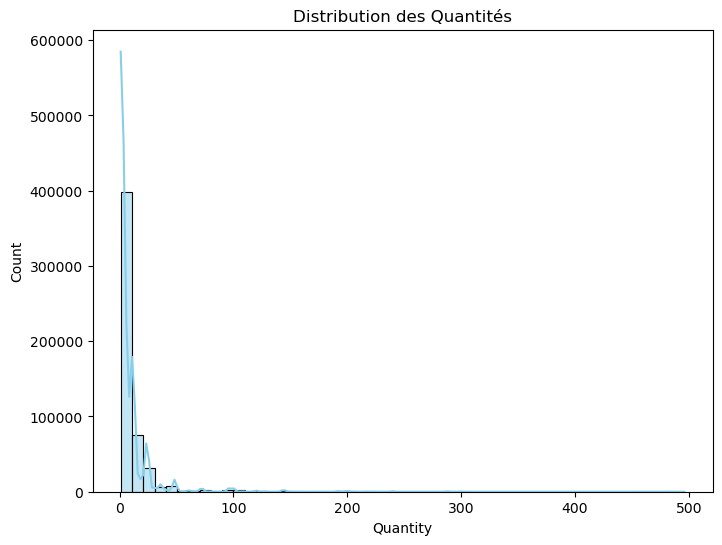

In [ ]:
# Explorer les distributions des différentes variables
# Distribution de la quantité
plt.figure(figsize=(8, 6))
sns.histplot(df['Quantity'], bins=50, kde=True, color='skyblue')
plt.title('Distribution des Quantités')
plt.show()

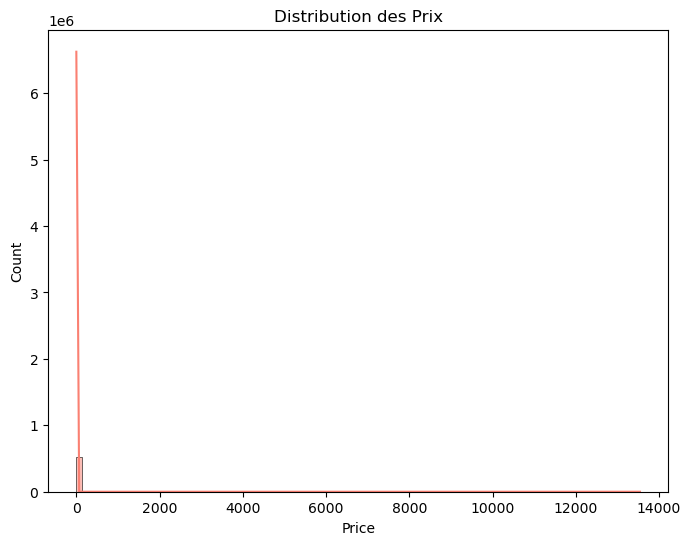

In [ ]:
# Distribution du prix
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'], bins=100, kde=True, color='salmon')
plt.title('Distribution des Prix')
plt.show()

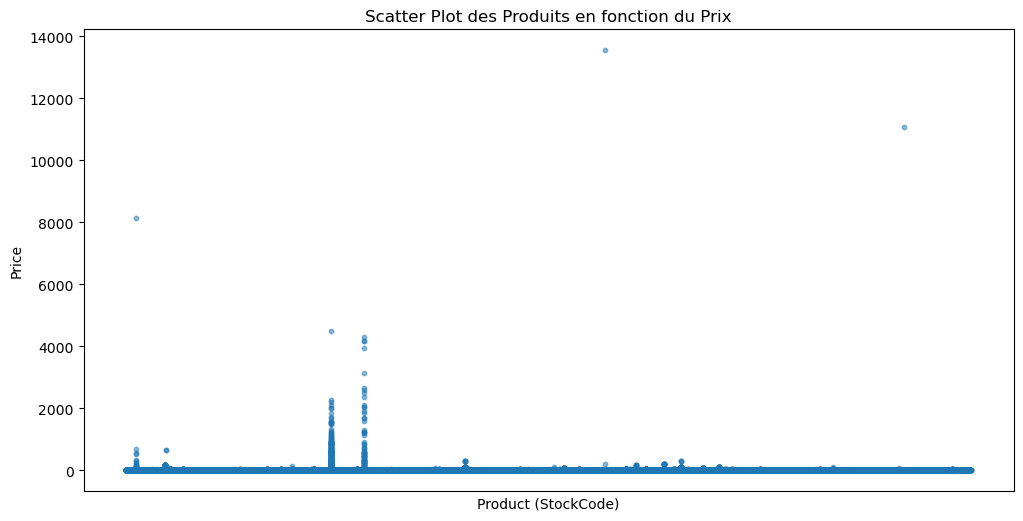

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df['StockCode'], df['Price'], alpha=0.5, s=10)  # 's' contrôle la taille des points
plt.xlabel("Product (StockCode)")
plt.ylabel("Price")
plt.xticks([])  # Masquer les labels des produits s'il y en a trop
plt.title("Scatter Plot des Produits en fonction du Prix")
plt.show()

In [ ]:
# Compter le nombre de produits uniques dans la colonne 'Description'
nombre_produits_uniques = df['Description'].nunique()
print(f"Nombre de produits uniques : {nombre_produits_uniques}")

Nombre de produits uniques : 4024


In [ ]:
# Trouver les StockCode associés à plus d'une description
multiple_descriptions = df.groupby('StockCode')['Description'].nunique()
stockcodes_with_multiple_descriptions = multiple_descriptions[multiple_descriptions > 1].index

# Filtrer le DataFrame pour garder uniquement les StockCodes ayant plusieurs descriptions
df_multiple_desc = df[df['StockCode'].isin(stockcodes_with_multiple_descriptions)]

# Supprimer les doublons pour voir chaque StockCode avec une de ses descriptions unique
df_unique_descriptions = df_multiple_desc[['StockCode', 'Description']].drop_duplicates()

# Afficher les résultats
print("Exemples de StockCodes avec plusieurs descriptions :")
print(df_unique_descriptions.sort_values('StockCode').head(20))  # Affiche les 10 premiers exemples

Exemples de StockCodes avec plusieurs descriptions :
       StockCode                          Description
138080    16156L                        WRAP CAROUSEL
47284     16156L                       WRAP, CAROUSEL
6467      17107D  FLOWER FAIRY,5 SUMMER B'DRAW LINERS
347764    17107D    FLOWER FAIRY 5 SUMMER DRAW LINERS
315743    17107D         FLOWER FAIRY 5 DRAWER LINERS
243736     20622                  VIP PASSPORT COVER 
1860       20622                   VIPPASSPORT COVER 
93         20725              LUNCH BAG RED RETROSPOT
58132      20725                 LUNCH BAG RED SPOTTY
415        20914  SET/5 RED RETROSPOT LID GLASS BOWLS
58121      20914     SET/5 RED SPOTTY LID GLASS BOWLS
2517       21109    LARGE CAKE TOWEL, CHOCOLATE SPOTS
28859      21109     LARGE CAKE TOWEL CHOCOLATE SPOTS
6221       21112        SWISS ROLL TOWEL, PINK  SPOTS
65153      21112         SWISS ROLL TOWEL PINK  SPOTS
502207     21175        GIN AND TONIC DIET METAL SIGN
119        21175          GIN

## Préparer les données pour l'algorithme Apriori

In [ ]:
# 1. Créer une table binaire pour chaque produit par transaction (Invoice)
basket_sets = df.pivot_table(index='Invoice',
                             columns='StockCode',
                             values='Quantity',
                             aggfunc='sum').fillna(0)

# 2. Transformer les quantités en booléens (1 = présent, 0 = absent) avec map pour le type booléen
basket_sets = (basket_sets > 0).astype(bool)

In [ ]:
basket_sets.head(5)

StockCode  10002  10080  10120  10123C  10124A  10124G  10125  10133  10135  \
Invoice                                                                       
536365     False  False  False   False   False   False  False  False  False   
536366     False  False  False   False   False   False  False  False  False   
536367     False  False  False   False   False   False  False  False  False   
536368     False  False  False   False   False   False  False  False  False   
536369     False  False  False   False   False   False  False  False  False   

StockCode  11001  ...      M   PADS   POST      S  gift_0001_10  gift_0001_20  \
Invoice           ...                                                           
536365     False  ...  False  False  False  False         False         False   
536366     False  ...  False  False  False  False         False         False   
536367     False  ...  False  False  False  False         False         False   
536368     False  ...  False  False  False  False         False         False   
536369     False  ...  False  False  False  False         False         False   

StockCode  gift_0001_30  gift_0001_40  gift_0001_50      m  
Invoice                                                     
536365            False         False         False  False  
536366            False         False         False  False  
536367            False         False         False  False  
536368            False         False         False  False  
536369            False         False         False  False  

[5 rows x 3920 columns]

## Analyse des Règles d’Association Un seul produits avec l’Algorithme Apriori

In [ ]:
# 3. Exécuter l'algorithme Apriori avec un support minimal plus faible, par exemple 0.03 au lieu de 0.05
frequent_itemsets = apriori(basket_sets, min_support=0.03, use_colnames=True)

# Compter le nombre d'ensembles d'items fréquents
num_itemsets = len(frequent_itemsets)

# 4. Générer les règles d'association avec une confiance minimale plus basse, par exemple 0.5 au lieu de 0.6
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5, num_itemsets=num_itemsets)

# 5. Filtrer les règles pour un lift supérieur à 3 au lieu de 5 pour obtenir des associations plus faibles
filtered_rules = rules[(rules['lift'] >7) & (rules['confidence'] > 0.5)]

# 6. Afficher les règles d'association filtrées
filtered_rules_display = filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
# Trier d'abord par lift, puis par confiance, puis par support
rules_sorted = filtered_rules_display .sort_values(by=['lift', 'confidence', 'support'], ascending=False)
print(rules_sorted.head(10))

   antecedents consequents   support  confidence       lift
6      (22698)     (22697)  0.031818    0.826144  16.199106
7      (22697)     (22698)  0.031818    0.623889  16.199106
11     (22698)     (22699)  0.030056    0.780392  14.568543
10     (22699)     (22698)  0.030056    0.561090  14.568543
9      (22697)     (22699)  0.038564    0.756170  14.116354
8      (22699)     (22697)  0.038564    0.719925  14.116354
12     (22726)     (22727)  0.032170    0.652041  12.346508
13     (22727)     (22726)  0.032170    0.609152  12.346508
2      (22384)     (20725)  0.030509    0.555963   7.056293


In [ ]:
# Créer un dictionnaire qui mappe chaque StockCode à sa Description
stockcode_to_desc = df[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()

# Afficher quelques exemples
print(list(stockcode_to_desc.items())[:5])  # Vérifiez le début du dictionnaire

[('85123A', 'CREAM HANGING HEART T-LIGHT HOLDER'), ('71053', 'WHITE MOROCCAN METAL LANTERN'), ('84406B', 'CREAM CUPID HEARTS COAT HANGER'), ('84029G', 'KNITTED UNION FLAG HOT WATER BOTTLE'), ('84029E', 'RED WOOLLY HOTTIE WHITE HEART.')]


In [ ]:
# Fonction pour obtenir les descriptions des produits dans une règle
def get_product_names(itemset, stockcode_to_desc):
    return [stockcode_to_desc.get(item, item) for item in itemset]

# Appliquer la fonction pour ajouter les descriptions aux règles
filtered_rules['antecedents_names'] = filtered_rules['antecedents'].apply(lambda x: get_product_names(x, stockcode_to_desc))
filtered_rules['consequents_names'] = filtered_rules['consequents'].apply(lambda x: get_product_names(x, stockcode_to_desc))

# Afficher les règles avec les noms des produits
filtered_rules_display = filtered_rules[['antecedents_names', 'consequents_names', 'support', 'confidence', 'lift']]
rules_sorted = filtered_rules_display.sort_values(by=['lift', 'confidence', 'support'], ascending=False)
print(rules_sorted.head(10))

                     antecedents_names                   consequents_names  \
6     [PINK REGENCY TEACUP AND SAUCER]   [GREEN REGENCY TEACUP AND SAUCER]   
7    [GREEN REGENCY TEACUP AND SAUCER]    [PINK REGENCY TEACUP AND SAUCER]   
11    [PINK REGENCY TEACUP AND SAUCER]  [ROSES REGENCY TEACUP AND SAUCER ]   
10  [ROSES REGENCY TEACUP AND SAUCER ]    [PINK REGENCY TEACUP AND SAUCER]   
9    [GREEN REGENCY TEACUP AND SAUCER]  [ROSES REGENCY TEACUP AND SAUCER ]   
8   [ROSES REGENCY TEACUP AND SAUCER ]   [GREEN REGENCY TEACUP AND SAUCER]   
12        [ALARM CLOCK BAKELIKE GREEN]         [ALARM CLOCK BAKELIKE RED ]   
13         [ALARM CLOCK BAKELIKE RED ]        [ALARM CLOCK BAKELIKE GREEN]   
2            [LUNCH BAG PINK POLKADOT]              [LUNCH BAG RED SPOTTY]   

     support  confidence       lift  
6   0.031818    0.826144  16.199106  
7   0.031818    0.623889  16.199106  
11  0.030056    0.780392  14.568543  
10  0.030056    0.561090  14.568543  
9   0.038564    0.756170  14.

/var/folders/jm/93f5251j4nx_22tgqfl2vph40000gn/T/ipykernel_29588/949608519.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rules['antecedents_names'] = filtered_rules['antecedents'].apply(lambda x: get_product_names(x, stockcode_to_desc))
/var/folders/jm/93f5251j4nx_22tgqfl2vph40000gn/T/ipykernel_29588/949608519.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rules['consequents_names'] = filtered_rules['consequents'].apply(lambda x: get_product_names(x, stockcode_to_desc))


L'algorithme A priori a été utilisé pour générer des règles d'association centrées sur des produits spécifiques, chaque règle ayant un unique conséquent. Les résultats montrent plusieurs relations intéressantes entre les produits, accompagnées de métriques clés comme le support, la confiance, et le lift.

1. **Relations entre les tasses Regency** :  
   - Le produit **Pink Regency Teacup and Saucer** est fortement associé à **Green Regency Teacup and Saucer**, avec un **lift** de 16.20 et une **confiance** de 82.61%.  
   - Inversement, **Green Regency Teacup and Saucer** est également associé à **Pink Regency Teacup and Saucer**, mais avec une confiance légèrement plus faible (62.39%), ce qui reflète une asymétrie dans la relation.  
   - Une association similaire est observée avec **Roses Regency Teacup and Saucer**, où des **lifts** élevés (~14.57) indiquent des relations significatives. Cela montre que ces produits de la gamme Regency sont souvent achetés ensemble.

2. **Relations entre les réveils Bakelite** :  
   - Les produits **Alarm Clock Bakelike Green** et **Alarm Clock Bakelike Red** sont étroitement liés, avec des **lifts** de 12.35, indiquant une corrélation significative. Toutefois, la **confiance** est modérée (65.20% pour Green → Red et 60.91% pour Red → Green), suggérant une probabilité d'achat croisée raisonnable mais non dominante.

3. **Relations entre les sacs à déjeuner** :  
   - Le **Lunch Bag Pink Polkadot** est associé au **Lunch Bag Red Spotty** avec un **lift** de 7.05 et une **confiance** de 55.60%. Bien que le lift soit plus modeste comparé aux autres règles, il reste significatif, montrant que ces sacs sont souvent choisis ensemble.

Ces résultats permettent d'identifier des combinaisons de produits populaires, ce qui peut guider des recommandations, la mise en place de promotions croisées, ou la gestion des stocks dans une logique d'optimisation des ventes.

## Analyse des Règles d’Association Multi-Produits avec l’Algorithme Apriori

In [ ]:
# 1. Créer une table binaire pour chaque produit par transaction (Invoice)
basket_sets = df.pivot_table(index='Invoice',
                             columns='StockCode',
                             values='Quantity',
                             aggfunc='sum').fillna(0)

# 2. Transformer les quantités en booléens (1 = présent, 0 = absent)
basket_sets = (basket_sets > 0).astype(bool)

# 3. Exécuter l'algorithme Apriori avec min_support et max_len pour générer des ensembles d'items de plusieurs produits
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True, max_len=3)

num_transactions = len(basket_sets)
# 4. Générer des règles d'association avec une confiance et un lift plus élevés, en enlevant le paramètre num_itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1, num_itemsets= num_transactions)


rules = rules[(rules['lift'] > 0.5) & (rules['confidence'] > 0.1)]
rules = rules[rules['antecedents'].apply(lambda x: len(x) >= 1)]
# 5. Ajouter les descriptions des produits pour rendre les règles plus compréhensibles
rules['antecedents_names'] = rules['antecedents'].apply(lambda x: get_product_names(x, stockcode_to_desc))
rules['consequents_names'] = rules['consequents'].apply(lambda x: get_product_names(x, stockcode_to_desc))

# 6. Afficher les règles avec plusieurs produits dans les antécédents
rules_display = rules[['antecedents_names', 'consequents_names', 'support', 'confidence', 'lift']]
# Trier d'abord par lift, puis par confiance, puis par support
rules_sorted = rules_display.sort_values(by=['lift', 'confidence', 'support'], ascending=False)
print(rules_sorted.head(10))

                                antecedents_names  \
3323  [HERB MARKER ROSEMARY, HERB MARKER PARSLEY]   
3326                          [HERB MARKER THYME]   
3324     [HERB MARKER THYME, HERB MARKER PARSLEY]   
3325                       [HERB MARKER ROSEMARY]   
3330       [HERB MARKER THYME, HERB MARKER BASIL]   
3331                       [HERB MARKER ROSEMARY]   
3329    [HERB MARKER ROSEMARY, HERB MARKER BASIL]   
3332                          [HERB MARKER THYME]   
1518                          [HERB MARKER THYME]   
1517                       [HERB MARKER ROSEMARY]   

                                consequents_names   support  confidence  \
3323                          [HERB MARKER THYME]  0.010220    0.944186   
3326  [HERB MARKER ROSEMARY, HERB MARKER PARSLEY]  0.010220    0.856540   
3324                       [HERB MARKER ROSEMARY]  0.010220    0.953052   
3325     [HERB MARKER THYME, HERB MARKER PARSLEY]  0.010220    0.845833   
3330                       [HERB MARKER R

La première ligne de ce tableau représente la règle d'association avec le **plus grand lift**, car j'ai trié les résultats dans l'ordre décroissant du lift, suivi par la confidence et le support. Cette règle indique que lorsqu'un client achète les articles *HERB MARKER ROSEMARY* et *HERB MARKER PARSLEY* (présents dans `antecedents_names`), il est très probable (confidence = **94,42%**) qu'il achète également *HERB MARKER THYME* (présent dans `consequents_names`). Le **lift** de cette règle, égal à **78.327221**, montre que cette association est environ 78 fois plus probable que si les articles étaient achetés indépendamment. Cela en fait une règle particulièrement intéressante pour des recommandations ou du regroupement de produits.

## Graphique des Associations de Produits : Visualisation des Relations Basées sur le Lift, la Confiance et le Support

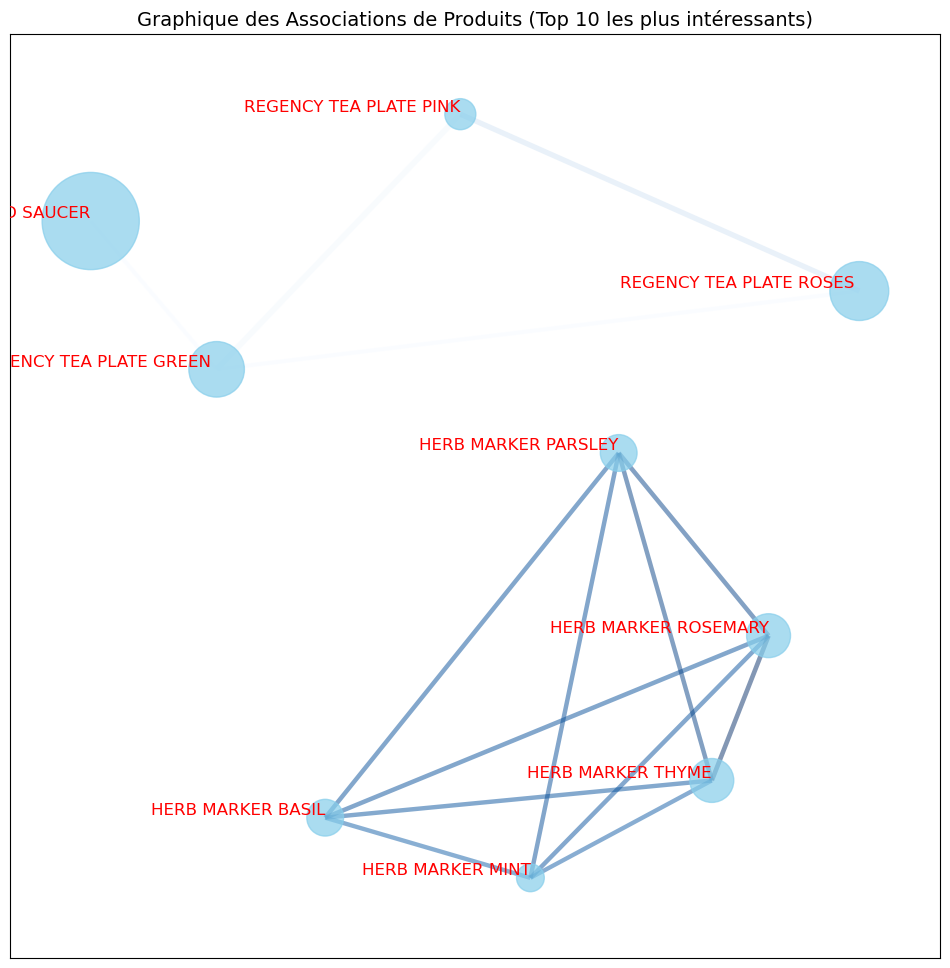

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

filtered_rules = rules_display

# Trier les règles par lift, confiance, puis support (ordre décroissant)
filtered_rules_sorted = filtered_rules.sort_values(by=['lift', 'confidence', 'support'], ascending=False)

# Sélectionner les 10 meilleures règles après le tri
top_rules = filtered_rules_sorted.head(40)

# Créer un graphe vide
G = nx.Graph()

# Ajouter des nœuds et des arêtes
for _, row in top_rules.iterrows():
    antecedents = row['antecedents_names']
    consequents = row['consequents_names']

    # Ajouter les arêtes pour les produits
    for antecedent in antecedents:
        for consequent in consequents:
            G.add_edge(antecedent, consequent, weight=row['support'], lift=row['lift'], confidence=row['confidence'])

# Calculer la taille des nœuds en fonction du support des produits
node_sizes = [filtered_rules_sorted[filtered_rules_sorted['antecedents_names'].apply(lambda x: item in x)].shape[0] * 100 for item in G.nodes()]

# Calculer l'épaisseur des arêtes en fonction du support
edge_widths = [G[u][v]['weight'] * 300 for u, v in G.edges()]  # Ajuste selon le besoin

# Calculer la couleur des arêtes en fonction du lift
edge_colors = [G[u][v]['lift'] * 100 for u, v in G.edges()]

# Choisir une disposition appropriée
pos = nx.spring_layout(G)

# Tracer le graphe
plt.figure(figsize=(12, 12))

# Dessiner les nœuds avec une taille en fonction de leur fréquence d'achat
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)

# Dessiner les arêtes avec une largeur et une couleur en fonction du support et du lift
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, edge_cmap=plt.cm.Blues, alpha=0.5)

# Récupérer les noms des produits pour les nœuds
product_names = {node: get_product_names([node], stockcode_to_desc)[0] for node in G.nodes()}

# Afficher les labels des produits (noms des produits)
nx.draw_networkx_labels(G, pos, labels=product_names, font_size=12, font_color='r', font_family='sans-serif', verticalalignment='bottom', horizontalalignment='right')

# Ajouter un titre
plt.title("Graphique des Associations de Produits (Top 10 les plus intéressants)", fontsize=14)

# Afficher le graphique
plt.show()

Le graphique des associations met en évidence deux groupes principaux de produits fortement connectés. 

Le premier groupe est composé des produits **Herb Marker Parsley**, **Herb Marker Rosemary**, **Herb Marker Thyme**, **Herb Marker Basil**, et **Herb Marker Mint**, formant un graphe complet. Ces produits sont très associés, indiquant qu’ils sont fréquemment achetés ensemble. 

Le second groupe, situé plus haut dans le graphique, forme un triangle relié par un lien additionnel. Ce triangle inclut les produits **Regency T Plate Pink**, **Regency T Plate Roses**, et **Regency T Plate Green**, suggérant une forte corrélation entre ces articles avec une légère extension pour un autre produit lié. 

Cette organisation reflète des schémas d'achat spécifiques, permettant d'identifier des ensembles de produits souvent combinés dans les paniers des clients.